<a href="https://colab.research.google.com/github/a1kayda/RF_fingerprinting/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import libs#




In [215]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [216]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data preprocessing#


In [360]:
colnames = ["S_Mean", "S_Max-Min", "S_Max-|Min|", "S_sumYup - sumYdn", "S_(Max-Mean)/(Mean-Min))", "S_numYup - numYdn", 
            "S_maxBd", "S_RangeJDy", "S_F", 
            "L_Mean", "L_Max-Min", "L_Max-|Min|", "L_sumYup - sumYdn", "L_(Max-Mean)/(Mean-Min))", "L_numYup - numYdn", 
            "L_maxBd", "L_RangeJDy", "L_F", "L_Ph",
            "y"]

phase_colnames = []
abs_colnames = []
imag_colnames = []
real_colnames = []
for f_name in colnames:
    phase_colnames.append(f_name + "_phase")
    abs_colnames.append(f_name + "_abs")
    real_colnames.append(f_name + "_real")
    imag_colnames.append(f_name + "_imag")

data_abs = pd.read_csv('/content/drive/MyDrive/Alkayda/Multipath_dataset_ABS_no_CFO_comp.txt', sep=",", names=abs_colnames, header=None)
data_angle = pd.read_csv('/content/drive/MyDrive/Alkayda/Multipath_dataset_PHASE_no_CFO_comp.txt', sep=",", names=phase_colnames, header=None)

data_abs.reset_index(drop=True, inplace=True)
data_abs.drop("y_abs", axis=1, inplace=True)
data_angle.reset_index(drop=True, inplace=True)

data = pd.concat([data_abs, data_angle], axis=1)

data_X = data.drop("y_phase", axis=1).replace([np.inf, -np.inf, np.nan], 0)
data_y = data["y_phase"]
data_y = data_y.values-2
data = data.replace([np.inf, -np.inf, np.nan], 0)

#data.reset_index()data_y = 

data_y.shape

(6900, 1)

In [361]:
X = np.array(data_X)
y = np.array(data_y)

In [362]:
# X_pca = PCA(n_components=2).fit_transform(X)
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y, cmap='autumn')

In [363]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 55,
                                                        test_size = 0.3, shuffle=True, stratify=y)

#DT + RF + feature importances#


In [364]:
DT = DecisionTreeClassifier(random_state=60)
DT.fit(X_train, y_train)

y_pred = DT.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("acc:", acc)

acc: 0.7579710144927536


In [365]:
f1 = []
y_test_1 = y_test+1
y_pred = y_pred+1
for i in np.arange(1,11):
  print(i-1, f1_score((y_test_1*(y_test_1==i)/i), (y_pred*(y_pred==i))/i))


0 0.7598425196850394
1 0.7279279279279279
2 0.8180112570356473
3 0.7191011235955056
4 0.8370786516853933
5 0.7777777777777778
6 0.7914438502673796
7 0.888283378746594
8 0.6442577030812325
9 0.6042780748663101


In [366]:
rf = RandomForestClassifier(n_estimators=300, criterion= "entropy", random_state=29)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9


In [367]:
y_test_1 = y_test+1
y_pred = y_pred+1
for i in np.arange(1,11):
  print(i-1, f1_score((y_test_1*(y_test_1==i)/i), (y_pred*(y_pred==i))/i))

0 0.8549323017408124
1 0.8397212543554006
2 0.930728241563055
3 0.9111747851002865
4 0.9717514124293786
5 0.9169054441260744
6 0.9436997319034852
7 0.9805013927576602
8 0.8309455587392551
9 0.8555240793201134


<function matplotlib.pyplot.show>

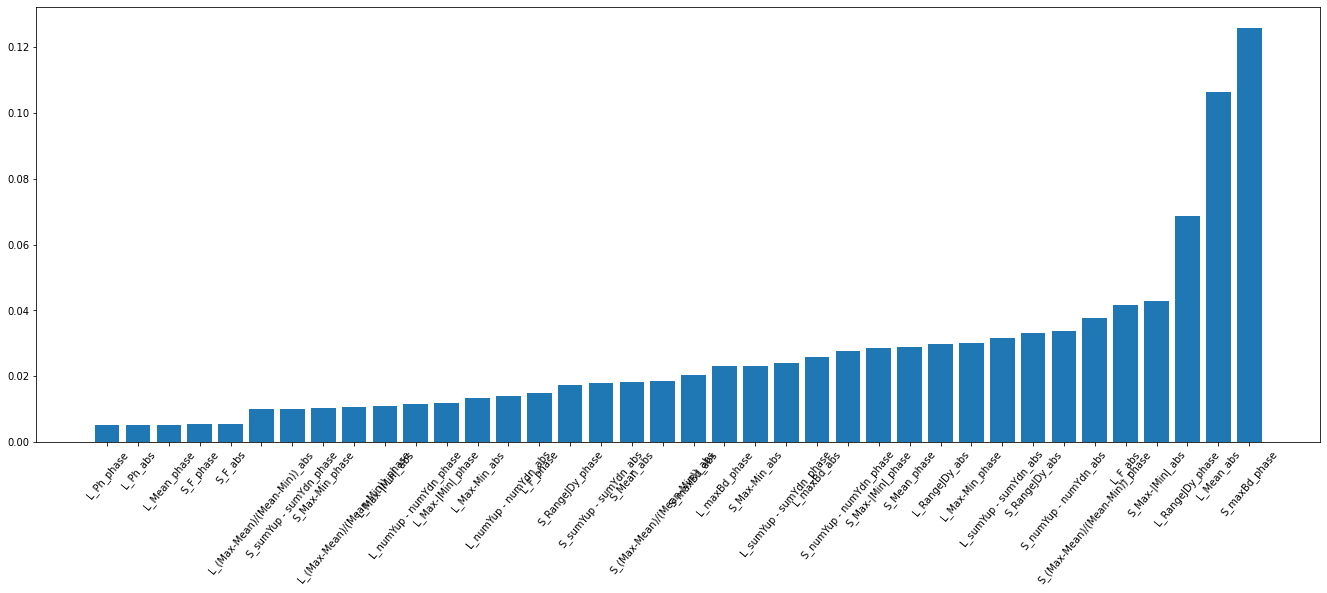

In [368]:
plt.figure(figsize=(23,8))
f = pd.DataFrame({'features':data_X.columns, 'importances':rf.feature_importances_}).sort_values('importances').to_numpy()
plt.bar(f[:,0], f[:,1])
plt.xticks(rotation=50)
plt.show

In [369]:
th = np.arange(0.02,0.05,0.005)
features = [data_X.columns[rf.feature_importances_ > i] for i in th]
n_features = [np.size(i) for i in features]

In [386]:
data_X[data_X.columns[rf.feature_importances_ > 0.03]]

,S_Max-|Min|_abs,S_numYup - numYdn_abs,S_RangeJDy_abs,L_Mean_abs,L_sumYup - sumYdn_abs,L_F_abs,S_(Max-Mean)/(Mean-Min))_phase,S_maxBd_phase,L_Max-Min_phase,L_RangeJDy_phase
0,29.413,13.550,1.58710,-0.000119,28.391,2.0547,8,8.8356,1.7543,7.2552
1,33.977,15.781,1.77030,0.000520,33.122,2.1067,2,6.2514,2.1234,6.4782
2,40.274,18.860,1.68890,0.002062,37.303,2.1200,14,5.9766,2.7010,5.3170
3,44.245,20.979,1.83530,0.002137,42.281,2.2143,12,6.1169,2.6554,5.3564
4,47.824,23.061,2.03320,0.002290,45.757,2.0927,10,5.8451,2.9986,4.9340
...,...,...,...,...,...,...,...,...,...,...
6895,50.799,23.612,1.64630,-0.013775,57.464,1.8879,0,9.3454,3.8996,5.6982
6896,40.075,19.065,1.31560,-0.010316,43.960,1.7078,20,10.3410,9.0728,16.2090
6897,41.411,18.828,1.22240,-0.018105,41.396,1.5148,6,10.7610,15.4010,30.4260
6898,38.433,17.324,0.96908,-0.019588,39.473,1.1622,-16,3.8944,7.8220,13.1170


In [370]:
rf_1 = RandomForestClassifier(n_estimators=100, criterion= "entropy")
acc = []
for i in th:
      X_i = data_X[features[int(np.where(abs(th - i) < 0.00001)[0])]]
      scaler.fit(X_i)
      X_train, X_test, y_train, y_test = train_test_split(X_i, y,random_state = 55, test_size = 0.3, shuffle=True, stratify=y)
      rf_1.fit(X_train, y_train)
      y_pred = rf_1.predict(X_test)
      acc.append(accuracy_score(y_test, y_pred))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConv

<function matplotlib.pyplot.show>

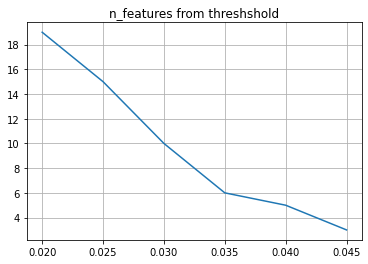

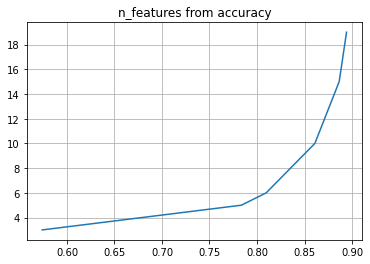

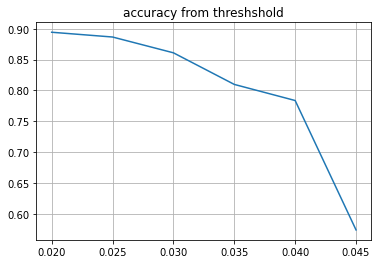

In [371]:
plt.figure()
plt.title("n_features from threshshold")
plt.plot(th, n_features)
plt.grid(True)
plt.figure()
plt.title("n_features from accuracy")
plt.plot(acc, n_features)
plt.grid(True)
plt.figure()
plt.title("accuracy from threshshold")
plt.plot(th, acc)
plt.grid(True)
plt.show

In [372]:
ncol = data_X.columns[rf.feature_importances_ > 0.03]
ncol

Index(['S_Max-|Min|_abs', 'S_numYup - numYdn_abs', 'S_RangeJDy_abs',
       'L_Mean_abs', 'L_sumYup - sumYdn_abs', 'L_F_abs',
       'S_(Max-Mean)/(Mean-Min))_phase', 'S_maxBd_phase', 'L_Max-Min_phase',
       'L_RangeJDy_phase'],
      dtype='object')

In [373]:
X = data_X[data_X.columns[rf.feature_importances_ > 0.03]]
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 55,
                                                        test_size = 0.3, shuffle=True, stratify=y)

In [376]:
rf_2 = RandomForestClassifier(n_estimators=300, criterion= "entropy", random_state=29)
rf_2.fit(X_train, y_train)

y_pred = rf_2.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8753623188405797


In [377]:
y_test_1 = y_test+1
y_pred = y_pred+1
for i in np.arange(1,11):
  print(i, f1_score((y_test_1*(y_test_1==i)/i), (y_pred*(y_pred==i))/i))

1 0.8571428571428571
2 0.8286713286713288
3 0.8966789667896679
4 0.8739495798319329
5 0.9512893982808024
6 0.8781869688385271
7 0.912
8 0.9696969696969697
9 0.7861271676300577
10 0.8219178082191781


In [398]:
data_X.columns[rf_2.feature_importances_ > 0.03].shape

IndexError: ignored

In [396]:
nimportances = rf_2.feature_importances_
a = pd.DataFrame({'features':data_X.columns[rf_2.feature_importances_ > 0.03], 'importances':nimportances}).sort_values('importances').to_numpy()

plt.figure(figsize=(23,8))
plt.bar(a[:,0], a[:,1])
plt.xticks(rotation=50)
plt.show

IndexError: ignored

In [379]:
rf_2.feature_importances_

array([0.01826246, 0.02304145, 0.04294771, 0.01795592, 0.01859249,
       0.03369883, 0.02046821, 0.03304549, 0.00551803, 0.10644168,
       0.01337248, 0.01081903, 0.03157796, 0.01001974, 0.01389043,
       0.02582046, 0.02990758, 0.04176355, 0.00525965, 0.02874826,
       0.01046264, 0.02872785, 0.01003708, 0.03771538, 0.02778518,
       0.12593261, 0.01725141, 0.00545313, 0.00526453, 0.03019865,
       0.0119013 , 0.0241719 , 0.0106742 , 0.01148021, 0.02299194,
       0.06877411, 0.01492132, 0.00510515])

In [380]:
from sklearn.manifold import TSNE

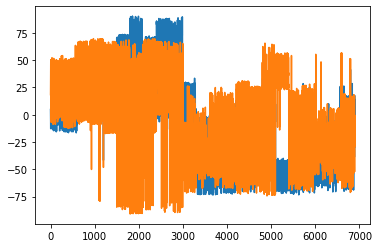

In [381]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
plt.plot(X_embedded)

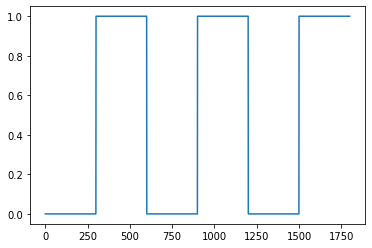

In [382]:
plt.plot(y[y<2])

In [383]:
plt.scatter(X_embedded[y<6, 0], X_embedded[y<6, 1], c=y[y<6])

IndexError: ignored

In [ ]:
X_embedded[y<2].shape

In [ ]:
X_2=X_embedded[y<2]
y_2 = y[y<2]

In [ ]:
plt.scatter(X_2[:,0], X_2[:,1], c=y_2)

In [ ]:
clustering = DBSCAN(eps=0.223, n_jobs=-1)
prediction = clustering.fit_predict(X_cutted)
pred = prediction[np.argwhere(y == 1)]
print(np.unique(clustering.labels_))

In [ ]:
X_embedded

In [ ]:
# from sklearn.model_selection import cross_validate, StratifiedShuffleSplit

# cv = StratifiedShuffleSplit(n_splits=5, random_state=3)
# score = cross_validate(rf, X_train, y_train, cv=cv, scoring='accuracy', return_train_score=True)
# print('rf', 'mean test score :', round(np.mean(score['test_score']),3), '\n', 'train scores:', score['train_score'],  '\n', 'test scores:', score['test_score'], '\n')

In [ ]:
# from sklearn.neural_network import MLPClassifier
# MLP = MLPClassifier(activation = 'relu', max_iter = 300, solver='adam', alpha=3e-4,
#                         hidden_layer_sizes=(37, 250), random_state=10)
# MLP.fit(X_train,y_train)

# y_pred = MLP.predict(X_train)
# acc = accuracy_score(y_train, y_pred)
# print(acc)

# y_pred = MLP.predict(X_test)
# acc = accuracy_score(y_test, y_pred)
# print(acc)

# from sklearn.neural_network import MLPClassifier

# import torch
# import torch.nn as nn
# import torchsummary
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
#                                                         train=True, 
#                                                         transform=train_transform,
#                                                         target_transform=None,
#                                                         download=download)
# fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
#                                                        train=False, 
#                                                        transform=test_transform,
#                                                        target_transform=None,
#                                                        download=download)
# train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
#                                            batch_size=128,
#                                            shuffle=True,
#                                            num_workers=2)
# test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
#                                           batch_size=256,
#                                           shuffle=False,
#                                           num_workers=2)

# class TinyNeuralNetwork(nn.Module):
#     def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, hidden_layer_size=(4096, 2048)):
#         super(self.__class__, self).__init__()
#         self.model = nn.Sequential(
#             nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
#             # Your network structure comes here
#             nn.Linear(input_shape, hidden_layer_size[0]),
#             nn.Dropout(),
#             nn.ELU(),
#             nn.Linear(hidden_layer_size[0], hidden_layer_size[1]),
#             nn.Dropout(),
#             nn.ELU(),
#             nn.Linear(hidden_layer_size[1], num_classes),
#             nn.Dropout(),
#             nn.LogSoftmax(dim=1)
#         )
        
#     def forward(self, inp):       
#         out = self.model(inp)
#         return out

# torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

# model = TinyNeuralNetwork().to(device)
# opt = torch.optim.Adam(model.parameters(), lr=0.0001)
# loss_func = nn.functional.nll_loss

# num_epochs = 60
# def error(loader, model):
#     model.eval()
#     correct = 0
#     with torch.no_grad():
#         for data, target in loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             pred = output.argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     return 1 - correct / len(loader.dataset)

# epoch_train_accs, epoch_test_accs = [], []
# for epoch in range(num_epochs):
#     epoch_train_accs.append(error(train_loader, model))
#     epoch_test_accs.append(error(test_loader, model))

#     clear_output(True)
#     plt.plot(np.arange(len(epoch_train_accs)), epoch_train_accs, label='train error')
#     plt.plot(np.arange(len(epoch_test_accs)), epoch_test_accs, label='test error')
#     plt.legend()
#     plt.show()

#     model.train()
#     correct = 0
#     for data, target in train_loader:
#         opt.zero_grad()
#         output = model(data.to(device))
#         loss = loss_func(output.to(device), target.to(device))
#         loss.backward()
#         opt.step()

# print(f'Train accuracy: {1 - error(train_loader, model)}')
# print(f'Test accuracy: {1 - error(test_loader, model)}')